Heading estimation using data https://drive.google.com/file/d/15C9YKN56THOoxV-9ahO06rtfXDRw-3Fj/view?usp=drive_link

## 1. Layer S1
Implementation of layer S1 consists of loading images and applying series of transformations to convert an image into spike-wave tensor. We will load images with the help of Torchvision's `ImageFolder` dataset and PyTorch's `DataLoader`, but first, we need to prepare the image transform.

The whole pipeline of image transformation is as follows:<br> image >> grayscale image >> PyTorch's 3D tensor >> 4D tensor (time dimension) >> Gabor filters >> lateral inhibition >> intencity-to-latency encoding.

![SNN-encoding.png](assets/SNN-encoding.png)
    

In [1]:
import SpykeTorch.utils as utils

kernels = [	utils.GaborKernel(window_size = 3, orientation = 45+22.5),
            utils.GaborKernel(3, 90+22.5),
            utils.GaborKernel(3, 135+22.5),
            utils.GaborKernel(3, 180+22.5)]
feature_filter = utils.Filter(kernels, use_abs = True)

/home/yeliu/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
import SpykeTorch.utils as utils
import SpykeTorch.functional as sf
import torchvision.transforms as transforms

def time_dim(input):
    return input.unsqueeze(0)

transform = transforms.Compose(
    [transforms.Grayscale(),
    transforms.ToTensor(),
    time_dim,
    feature_filter,
    sf.pointwise_inhibition,
    utils.Intensity2Latency(number_of_spike_bins = 15, to_spike = True)])

To show the output of the transform, i.e. the corresponding spike-wave tensor, we plot each time-step separately for each feature until the 5th time-step. We also plot the accumulation of spikes over all of the features.

torch.Size([15, 4, 98, 98])


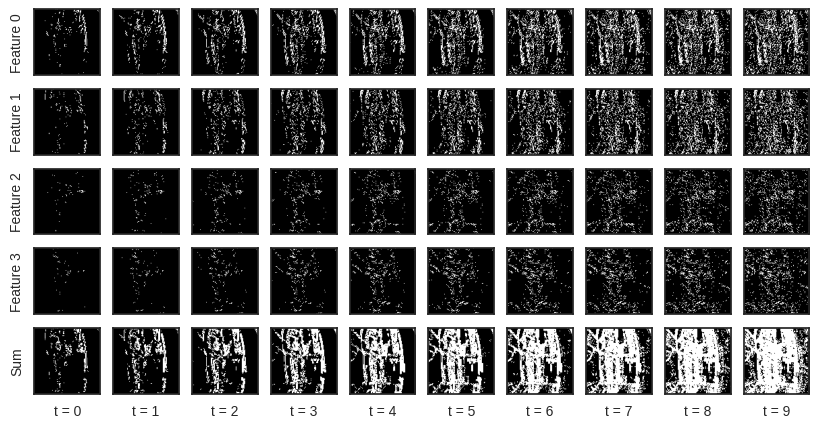

In [5]:
import numpy as np
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import random

dataset = ImageFolder("dataset/heading", transform) # adding transform to the dataset
sample_idx = random.randint(0, len(dataset) - 1)

sw = dataset[sample_idx][0]
print(sw.shape)
show_max_t = 10

plt.style.use('seaborn-v0_8-white')
plt_idx = 0
plt.figure(figsize=(10, 5))
for f in range(4):
    for t in range(show_max_t):
        plt_idx += 1
        ax = plt.subplot(5, show_max_t, plt_idx)
        plt.setp(ax, xticklabels=[])
        plt.setp(ax, yticklabels=[])
        if t == 0:
            ax.set_ylabel('Feature ' + str(f))
        plt.imshow(sw[t,f].numpy(),cmap='gray')
        if f == 3:
            ax = plt.subplot(5, show_max_t, plt_idx + show_max_t)
            plt.setp(ax, xticklabels=[])
            plt.setp(ax, yticklabels=[])
            if t == 0:
                ax.set_ylabel('Sum')
            ax.set_xlabel('t = ' + str(t))
            plt.imshow(sw[t].sum(dim=0).numpy(),cmap='gray')
plt.show()

To manage data loading, we use `DataLoader` provided by `torch.utils.data`. Here, we shuffle and split the whole dataset into two training (75%) and testing (25%) parts. Then, the corresponding indices will be given to data loaders.

In [6]:
# splitting training and testing sets
indices = list(range(len(dataset)))
random.shuffle(indices)
split_point = int(0.75*len(indices))
train_indices = indices[:split_point]
test_indices = indices[split_point:]
print("Size of the training set:", len(train_indices))
print("Size of the  testing set:", len(test_indices))

Size of the training set: 543
Size of the  testing set: 181


Since the transform from image to spike-wave tensor is time-consuming and static, we use `SpykeTorch.utils.CacheDataset` to cache spike-wave tensors for each image. `CacheDataset` is a wrapper that can work with other PyTorch's `dataset` objects as well.

In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler

dataset = utils.CacheDataset(dataset)
train_loader = DataLoader(dataset, sampler=SubsetRandomSampler(train_indices))
test_loader = DataLoader(dataset, sampler=SubsetRandomSampler(test_indices))

## 2. Layers C1 and S2
As mentioned before, C1 is a local pooling and S2 is a trainable convolutional layer. `SpykeTorch.snn` provides appropriate modules for each.

Layer C1 performs local pooling with window-size = 3 and stride = 2.

In [8]:
import SpykeTorch.snn as snn

pool_kernel_side = 1
pool_kernel_size = 2 * pool_kernel_side + 1
pool_stride = 2

conv_in_channel = sw.shape[1]
conv_out_channel = 18
conv_kernel_size = int((sw.shape[2] - 2 * pool_kernel_size) / pool_stride)

pool = snn.Pooling(kernel_size = pool_kernel_size, stride = pool_stride)
conv = snn.Convolution(in_channels=conv_in_channel, 
                       out_channels=conv_out_channel, 
                       kernel_size=conv_kernel_size)

stdp = snn.STDP(conv_layer = conv, learning_rate = (0.05, -0.015))

### 3.1 Training
Each input spike-wave tensor (given by the data loader) will be passed through pooling (C1) and convolutional (S2) layers. The output of S2 denotes the trajectory of potentials over all of the time-steps. In order to convert them to spikes, we call `SpykeTorch.functional.fire` on the potentials with the desired threshold. When the output is ready, we find winners (here we have only one winner) to perform plasticity. `SpykeTorch.functional.get_k_winners` function, finds winner neurons first based on the earliest spike and then, based on the maximum potential. By providing input and output spike-wave and the potential tensors as well as the winners, STDP can be applied on layer S2.

In [9]:
conv.reset_weight()
print("Starting Unsupervised Training ...")
for iter in range(20):
    print('\rIteration:', iter, end="")
    for data,_ in train_loader:
        for x in data:
            x = pool(x)
            p = conv(x)
            o, p = sf.fire(p, conv_out_channel, return_thresholded_potentials=True)
            winners = sf.get_k_winners(p, kwta=1, inhibition_radius=0, spikes=o)
            stdp(x, p, o, winners)
print()
print("Unsupervised Training is Done.")

Starting Unsupervised Training ...
Iteration: 19
Unsupervised Training is Done.


### 3.2 Reconstructing Features
To reconstruct S2 features, one can use the provided functions in `SpykeTorch.visualization` module. `get_deep_feature` function receives the features extracted by the previous layer and generates the recunstructions for the current layer. It also outputs the accumulative stride until the current layer to be used when reconstructing the features of the next layer (if any).

In [12]:
import SpykeTorch.visualization as vis
import torch

def plot_features(conv):
    feature = torch.stack([k() for k in kernels])
    cstride = (1,1)
    # C1 Features #
    feature,cstride = vis.get_deep_feature(feature, cstride, 
                                           (pool_kernel_size, pool_kernel_size), (pool_stride, pool_stride))
    # S2 Features #
    feature,cstride = vis.get_deep_feature(feature, cstride, (conv_kernel_size,conv_kernel_size), 
                                           (1,1), conv.weight)

    feature_idx = 0
    plt.figure(figsize=(6, 3))
    for r in range(conv_out_channel):
        ax = plt.subplot(3, 6, feature_idx+1)
        plt.xticks([])
        plt.yticks([])
        plt.setp(ax, xticklabels=[])
        plt.setp(ax, yticklabels=[])
        plt.imshow(feature[feature_idx].numpy(),cmap='gray')
        feature_idx += 1
    plt.show()

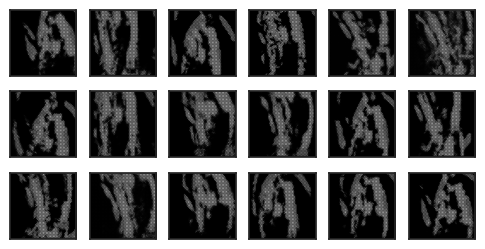

In [13]:
plot_features(conv)

### 3.3 Evaluation
Since we performed unsupervised training, we need to use an external classifier to do the inference. Here, we use the linear SVM provided by `sklearn`. Before using the SVM, we need to prepare the training and testing data (network's output vectors). We extract two kinds of vectors from S2: (1) potentials, and (2) binary spikes.

**Training vectors:**

In [14]:
train_x_spike = []
train_x_pot = []
train_y = []
for data,targets in train_loader:
    for x,t in zip(data, targets):
        x = pool(x)
        p = conv(x)
        o = sf.fire(p, 20)
        train_x_spike.append(o.reshape(-1).cpu().numpy())
        train_x_pot.append(p.reshape(-1).cpu().numpy())
        train_y.append(t)
train_x_spike = np.array(train_x_spike)
train_x_pot = np.array(train_x_pot)
train_y = np.array(train_y)

**Testing vectors:**

In [15]:
test_x_spike = []
test_x_pot = []
test_y = []
for data,targets in test_loader:
    for x,t in zip(data, targets):
        x = pool(x)
        p = conv(x)
        o = sf.fire(p, 20)
        test_x_spike.append(o.reshape(-1).cpu().numpy())
        test_x_pot.append(p.reshape(-1).cpu().numpy())
        test_y.append(t)
test_x_spike = np.array(test_x_spike)
test_x_pot = np.array(test_x_pot)
test_y = np.array(test_y)

**Classifier:**

In [16]:
from sklearn.svm import LinearSVC

clf_spike = LinearSVC(max_iter=200)
clf_pot = LinearSVC(max_iter=200)
clf_spike.fit(train_x_spike, train_y)
clf_pot.fit(train_x_pot, train_y)

/home/yeliu/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/yeliu/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(max_iter=200)

**Inference:**

In [17]:
predict_spike = clf_spike.predict(test_x_spike)
predict_pot = clf_pot.predict(test_x_pot)

error_spike = (test_y != predict_spike).sum()
error_pot = (test_y != predict_pot).sum()
print("    Spike-based error:", error_spike/len(predict_spike))
print("Potential-based error:", error_pot/len(predict_pot))

    Spike-based error: 0.9281767955801105
Potential-based error: 0.7292817679558011


## 4. Reinforcement Learning
In this section, we show how to train and evaluate layer S2 using R-STDP. First, we reset the weights of S2 and assing it a new `SpykeTorch.snn.STDP` object as the anti-STDP part of the R-STDP.

In [18]:
anti_stdp = snn.STDP(conv_layer = conv, learning_rate = (-0.05, 0.0005))

feature2class = np.arange(conv_out_channel)
print(feature2class)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


### 4.1 Training
Again, each spike-wave tensor is passed through C1 and S2 and the only one winner is chosen. Here, the classification or the decision of the network is the category assigned to the winner feature. If the decision is right (wrong), stdp (anti-stdp) will be applied.

In [19]:
def if_encourage(label, label_gt, num_iter, iter_threshold):
    # for the beginning iterations, need to be precise
    if num_iter < iter_threshold:
        return label == label_gt
    # for later iterations, allow small error
    return abs(label - label_gt) < 2

In [20]:
conv.reset_weight()
print("Starting Reinforcement Learning ...")
max_num_iteration = 40
for num_iter in range(max_num_iteration):
    print('\rIteration:', num_iter, end="")
    for data,targets in train_loader:
        for x,t in zip(data, targets):
            x = pool(x)
            p = conv(x)
            o, p = sf.fire(p, 20, return_thresholded_potentials=True)
            winners = sf.get_k_winners(p, kwta=1, inhibition_radius=0, spikes=o)
            if len(winners) != 0:
                if if_encourage(feature2class[winners[0][0]], t, num_iter, max_num_iteration / 2):
                    stdp(x, p, o, winners)
                else:
                    anti_stdp(x, p, o, winners)
print()
print("Reinforcement Learning is Done.")

Starting Reinforcement Learning ...
Iteration: 39
Reinforcement Learning is Done.


### 4.2 Reconstructing Features
We use the same procedure as the one in unsupervised learning section.

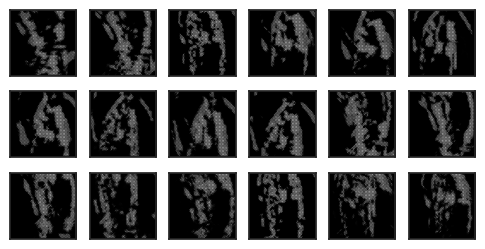

In [21]:
plot_features(conv)

### 4.3 Evaluation
Since the classification is done totally based on the S2 activities, there is no need for an external classifier. We feed the testing samples to the network and check how many errors it makes.

         Error: 0.5303867403314917
   Error Loose: 0.12154696132596685
Silent Samples: 0.0


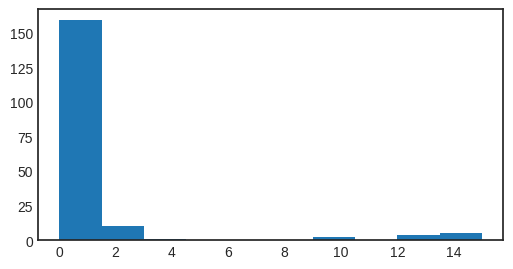

In [22]:
error = 0
error_loose = 0
silent = 0
total = 0
errors = []
for data,targets in test_loader:
    for x,t in zip(data, targets):
        total += 1
        x = pool(x)
        p = conv(x)
        o, p = sf.fire(p, 20, return_thresholded_potentials=True)
        winners = sf.get_k_winners(p, kwta=1, inhibition_radius=0, spikes=o)
        if len(winners) != 0:
            errors.append(abs(feature2class[winners[0][0]] - t))
            if abs(feature2class[winners[0][0]] - t) > 1:
                error_loose += 1
            if feature2class[winners[0][0]] != t:
                error += 1
        else:
            silent += 1
print("         Error:", error/total)
print("   Error Loose:", error_loose/total)
print("Silent Samples:", silent/total)

plt.figure(figsize=(6, 3))
plt.hist(errors, bins=10)
plt.show()